# Third Party Data Import - PlanetScope

This Jupyter Notebook demonstrates how to import **PlanetScope** data into Sentinel Hub and then access it.

We will use **Simple search** and **Order products** APIs[1].

 
Useful links:  
    [1] [TPDI API documentation](https://docs.sentinel-hub.com/api/latest/#/DATA_IMPORT_API/README)  
    [2] [TPDI API reference (Swagger documentation)](https://docs.sentinel-hub.com/api/latest/reference/#tag/dataimport_planet)  
    [3] [About PlanetScope data](https://docs.sentinel-hub.com/api/latest/#/data/PlanetScope)

## Imports and credentials

To run this JN, you will need:
- SH crednetinal (client_id and client_secret)
- Planet's APi key (PLANET_API_KEY)

If you are running the JN ouside of EDC JupyterHub (e.g., localy) you will have to provide these credentials manually in a cell starting with "# Credentials".

If you are running the JN on EDC JupyterHub and have activated an EDC SH subscription, you only need to provide your Planet API key.


In [92]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `SH_INSTANCE_ID`
* `SH_CLIENT_ID`
* `SH_CLIENT_SECRET`
* `SH_CLIENT_NAME`
* `GEODB_API_SERVER_URL`
* `GEODB_AUTH_CLIENT_ID`
* `GEODB_AUTH_AUD`
* `GEODB_AUTH_CLIENT_SECRET`
* `GEODB_API_SERVER_PORT`
* `GEODB_AUTH_DOMAIN`


In [93]:
# Credentials
client_id = %env SH_CLIENT_ID
client_secret = %env SH_CLIENT_SECRET
PLANET_API_KEY = %env MY_PLANET_API_KEY

In [94]:
import requests 
import json
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import os
import datetime
import dateutil.parser

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)


# Get token for the session
token = oauth.fetch_token(
    token_url='https://services.sentinel-hub.com/oauth/token',
    client_id=client_id, client_secret=client_secret
)

## Get my quota

To order PlanetScope data one needs to have enough avaliable quota tied to his SH account. To check your quota:

In [95]:
#Get my quota
url = f"https://services.sentinel-hub.com/dataimport/v1/quotas"

r = oauth.get(url=url)
r.json()

{'data': [{'id': 'd2c3ee95-f6f3-4035-b14c-529a8a4c753d',
   'datasetId': 'PLANET_SCOPE',
   'quotaSqkm': 50.0,
   'quotaUsed': 4.968239307460755}]}

We see that the user bought quota for 50 km^2 of PlanetScope data and has already ordered 5 km^2 of data. Here are more details about [Purshasing PlanetSope data](https://docs.sentinel-hub.com/api/latest/#/data/PlanetScope?id=purchasing-the-data).

## Search

In [96]:
# User's defiend search criteria
# aoi
#aoi = {'type': 'Polygon',
#  'coordinates': [[[12.560804463221928, 41.885177999999996],
#    [12.585804463221926, 41.885177999999996],
#    [12.585804463221926, 41.910178],
#    [12.560804463221928, 41.910178],
#    [12.560804463221928, 41.885177999999996]]]}

aoi = {"type": "Polygon", 
       "coordinates": [[[12.567054463221927, 41.891428], 
                        [12.579554463221926, 41.891428], 
                        [12.579554463221926, 41.903928], 
                        [12.567054463221927, 41.903928], 
                        [12.567054463221927, 41.891428]]]}
# dates
date_from = "2020-04-15T00:00:00.000Z"
date_to = "2020-04-17T00:00:00.000Z"

# max cloud coverage
maxcc = 30

In [99]:
# Search
url = "https://services.sentinel-hub.com/dataimport/v1/search"

query = {
    "provider": "PLANET",
    "planetApiKey": PLANET_API_KEY,
    "bounds": {
        "geometry": aoi
    },
    "data": [
        {
            "itemType": "PSScene4Band",
            "dataFilter": {
                "timeRange": {
                    "from": date_from,
                    "to": date_to
                },
                "maxCloudCoverage": maxcc
            }
        }
    ]
}

response = oauth.post(url, json=query)
response.raise_for_status()

results = response.json()
results

{'features': [{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20200416_093843_1003',
    'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20200416_093843_1003/assets/',
    'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20200416_093843_1003/thumb'},
   '_permissions': ['assets.udm:download',
    'assets.analytic:download',
    'assets.analytic_xml:download',
    'assets.analytic_dn:download',
    'assets.analytic_dn_xml:download',
    'assets.basic_analytic:download',
    'assets.basic_analytic_rpc:download',
    'assets.basic_analytic_dn:download',
    'assets.basic_analytic_dn_rpc:download',
    'assets.basic_analytic_xml:download',
    'assets.basic_analytic_dn_xml:download',
    'assets.basic_analytic_dn_nitf:download',
    'assets.basic_analytic_dn_rpc_nitf:download',
    'assets.basic_analytic_dn_xml_nitf:download',
    'assets.basic_analytic_nitf:download',
    'assets.basic_analytic_rpc_nitf

In [98]:
# Print out the most interesting metadata
search_results = [(feature["id"], feature["properties"]['acquired'], \
                   feature["properties"]['cloud_cover']) \
                   for feature in results["features"]]
print("Product id \t acquisition date & time \t cloud cover  ")
for item in search_results:
    print(item[0],   item[1],   item[2])

Product id 	 acquisition date & time 	 cloud cover  
20200416_093843_1003 2020-04-16T09:38:43.436748Z 0
20200415_100513_35_1058 2020-04-15T10:05:13.355052Z 0.03
20200415_091216_83_2257 2020-04-15T09:12:16.833103Z 0
20200415_100515_37_1058 2020-04-15T10:05:15.370415Z 0.03


In [115]:
# Additional filtering of search results by cloud coverage
item_ids = [feature['id'] for feature in results["features"] 
            if feature["properties"]['cloud_cover'] == 0]
item_ids

['20200416_093843_1003', '20200415_091216_83_2257']

## Order data import

In [11]:
url = "https://services.sentinel-hub.com/dataimport/v1/orders"

query['data'][0]["productBundle"] = "analytic"

name = "EDC demo 1"
payload = {
    "name": name,
    "input": query
}

response = oauth.post(url, json=payload)
response.raise_for_status()

order = response.json()

In [12]:
order_id = order['id']
area = order['sqkm']
print(f"Order {name}, id: {order_id}, area: {area} km^2")

Order EDC demo 1, id: 89f6057f-3b50-473f-9cd3-6e4f52666e27, area: 4.968239307460755 km^2


## Confirm the order

In [13]:
url = f"https://services.sentinel-hub.com/dataimport/v1/orders/{order_id}/confirm"

response = oauth.post(url)
response.raise_for_status()

In [ ]:
response.json()["status"]

# Check Status

In [ ]:
order_id = order_id

url = f"https://services.sentinel-hub.com/dataimport/v1/orders/{order_id}"

response = oauth.get(url)
response.raise_for_status()

order_status = response.json()

In [101]:
order_status["status"]

'DONE'

In [32]:
# Save the collection id
collection_id = order_status["collectionId"]

## List all orders

In [91]:
url = "https://services.sentinel-hub.com/dataimport/v1/orders"

response = oauth.get(url)
response.raise_for_status()

#response.json()

{'data': [{'id': '0122458c-4f49-40af-80c5-82adf504745a',
   'userId': '42f086c7-d327-4e93-ac15-48008abf24b2',
   'created': '2020-04-09T21:29:38.854Z',
   'name': 'South Budapest Industry estate, 2020',
   'collectionId': '3c4daecf-09f3-451c-8c3c-90e356cbd673',
   'provider': 'AIRBUS',
   'input': {'bounds': {'geometry': {'type': 'Polygon',
      'coordinates': [[[19.083411598048095, 47.32569590870299],
        [19.160900110588322, 47.32569590870299],
        [19.160900110588322, 47.38095740946729],
        [19.083411598048095, 47.38095740946729],
        [19.083411598048095, 47.32569590870299]]]},
     'properties': {}},
    'data': [{'constellation': 'PHR',
      'products': [{'id': 'f1ddfa74-68f8-4bcd-9cad-e57bd32d0257',
        'crsCode': 'urn:ogc:def:crs:EPSG::32634'}]}],
    'provider': 'AIRBUS'},
   'sqkm': 35.96,
   'status': 'DONE'},
  {'id': '01d61988-6aa2-4eeb-a293-890cb24372f2',
   'userId': '42f086c7-d327-4e93-ac15-48008abf24b2',
   'created': '2020-04-02T13:44:07.174Z',
 

## Access the data

### Prepare a bbox

In [19]:
minx, miny = aoi["coordinates"][0][0]
maxx, maxy = aoi["coordinates"][0][2]

### Prepare evalscript

In [56]:
# True color
evalscript_true_color = """
//VERSION=3
function setup() {
  return {
    input: [{"bands": ["B1", "B2", "B3"]}],
    output: { bands: 3}
  };
}

var f = 3000;
function evaluatePixel(sample) {
  return [sample.B3, sample.B2, sample.B1].map(s => s / f);
}
"""

In [57]:
# NDVI
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{"bands": ["B3", "B4"]}],
    output: { bands: 3}
  };
}

function evaluatePixel(sample) {
  var ndvi = (sample.B4 - sample.B3) / (sample.B4 + sample.B3)
  return colorBlend(ndvi, [0.0, 0.2, 0.6], [[1,0,0], [1,1,0], [0.1,0.30,0]])
}
"""

### Access data with SH process API

In [108]:
# Prepare process API request
body = {
    "input": {
        "bounds": {
            "bbox": [minx, miny, maxx, maxy],
            "properties":{
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            }
        },
        "data": [
            {
                "type": "CUSTOM",
                "dataFilter": {
                    "collectionId": collection_id,
                    "timeRange": {
                        "from": date_from,
                        "to": date_to
                    },
                }
            }
        ]
    },
    "evalscript": "",
    "output": {
        "height": 512,
        "width": 512,
        "responses": [
          {
            "identifier": "default",
            "format": {
                  "type": "image/jpeg",
                   "quality": 100
                }
          }
        ]
    }
}

In [109]:
def override_evalscript_in_body (body, evalscript):
    body ["evalscript"] = evalscript
    return body

In [110]:
response_true_color = oauth.post(
    'https://services.sentinel-hub.com/api/v1/process', 
    json=override_evalscript_in_body(body, evalscript_true_color)
)
response_ndvi = oauth.post(
    'https://services.sentinel-hub.com/api/v1/process', 
    json=override_evalscript_in_body(body, evalscript_ndvi)
)
if response_true_color.status_code == response_ndvi.status_code == 200:
    print("Success")

Success


In [ ]:
response_true_color.json()

In [113]:
import io
from PIL import Image

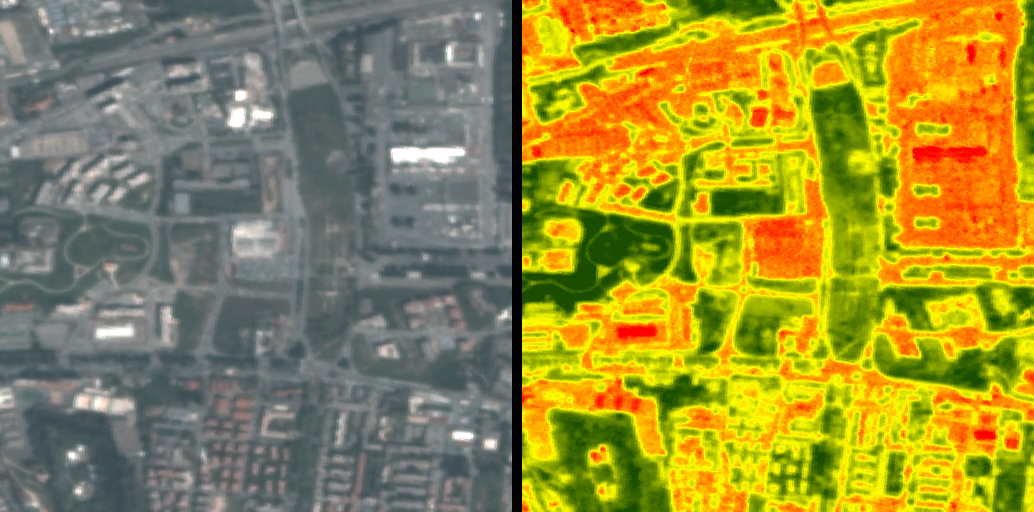

In [114]:
# Display true color and  NDVI
im1 = Image.open(io.BytesIO(response_true_color.content))
im2 = Image.open(io.BytesIO(response_ndvi.content))

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width+10, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width+10, 0))
    return dst

get_concat_h(im1, im2)

### Request S2 data for comparison

In [88]:
date_from = "2020-04-10T00:00:00.000Z" # We extend the time range, as there 
                                       # was no S2 image available for given
                                       # aoi and time range

evalscript_s2_true_color = """
//VERSION=3
function setup() {
  return {
    input: [{"bands": ["B02", "B03", "B04"]}],
    output: { bands: 3}
  };
}

function evaluatePixel(sample) {
  return [sample.B04*2.5, sample.B03*2.5, sample.B02*2.5];
}
"""


# Prepare process API request
body = {
    "input": {
        "bounds": {
            "bbox": [minx, miny, maxx, maxy],
            "properties":{
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            }
        },
        "data": [
            {
                "type": "S2L1C",
                "dataFilter": {
                    "timeRange": {
                        "from": date_from,
                        "to": date_to
                    },
                }
            }
        ]
    },
    "evalscript": "",
    "output": {
        "height": 512,
        "width": 512,
        "responses": [
          {
            "identifier": "default",
            "format": {
                  "type": "image/jpeg",
                   "quality": 100
                }
          }
        ]
    }
}

In [89]:
response_s2_true_color = oauth.post( \
            'https://services.sentinel-hub.com/api/v1/process',
            json=override_evalscript_in_body(body, 
                                             evalscript_s2_true_color))

In [105]:
stream = io.BytesIO(response_s2_true_color.content)
img_s2_true_color = Image.open(stream)

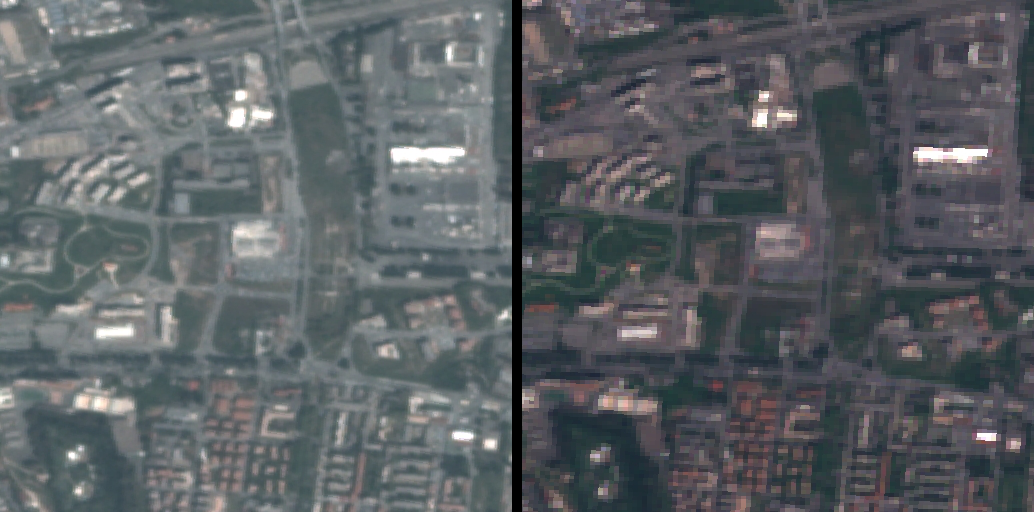

In [104]:
# Display PlanetScope true color on the left and S2 L1C on the right
get_concat_h(im1, img_s2_true_color)